In [1]:
from __future__ import division
import requests
import time as t
from mpl_toolkits.basemap import Basemap
from shapely.geometry import mapping, LineString
from matplotlib import pyplot as plt
import numpy as np
import os
import urllib
import json
import pandas as pd
from random import shuffle, choice
from geojson import Feature, Point, MultiPoint, FeatureCollection, dumps
import itertools
%matplotlib inline
import sys; sys.path.insert(0, os.path.abspath('..'));
import validator.validator as val
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)
from pyproj import transform, Proj

# Open Traffic Reporter Validation Service 

### 1. Generate Random Routes

In [2]:
mapzenKey = os.environ.get('MAPZEN_API')

In [3]:
routeList = val.get_routes_by_length('San Francisco', 1, 5, 10, mapzenKey)
# routeList = [({"home":{"lat":37.8261, "lon": -122.25872}}, {"work":{"lat":37.790168, "lon":-122.402264}})]

In [4]:
routeList

[({u'SBC': {'lat': 37.784822, 'lon': -122.397551}},
  {u'Pacific Image': {'lat': 37.759505, 'lon': -122.409}}),
 ({u'Tiffanys Donuts & Cafe': {'lat': 37.784466, 'lon': -122.433258}},
  {u'Atlas Home Comfort Systems Inc': {'lat': 37.756065, 'lon': -122.440173}}),
 ({u'Pacific Image': {'lat': 37.759505, 'lon': -122.409}},
  {u'Atlas Home Comfort Systems Inc': {'lat': 37.756065, 'lon': -122.440173}}),
 ({u'Hanging By A Thread': {'lat': 37.727017, 'lon': -122.465665}},
  {u'Sunrise Nursing Placement': {'lat': 37.722124, 'lon': -122.452119}}),
 ({u'Chronis Kreher Wloszek': {'lat': 37.791564, 'lon': -122.402593}},
  {u'David Hwang Inc': {'lat': 37.770033, 'lon': -122.414012}}),
 ({u'Access Capital': {'lat': 37.792737, 'lon': -122.404287}},
  {u'David Hwang Inc': {'lat': 37.770033, 'lon': -122.414012}}),
 ({u'Chronis Kreher Wloszek': {'lat': 37.791564, 'lon': -122.402593}},
  {u'101 Lombard Condominiums': {'lat': 37.804003, 'lon': -122.402091}}),
 ({u'David Hwang Inc': {'lat': 37.770033, 'lon

### 2. Iterate Through Routes and Score the Matches

In [ ]:
df = pd.DataFrame(columns=['route','noise','sample_rate','score','route_url','trace_attr_url','reporter_url'])
outDfRow = -1
saveResults = True

for i, rteCoords in enumerate(routeList):
    stName = rteCoords[0].keys()[0].encode("ascii", "ignore")
    endName = rteCoords[1].keys()[0].encode("ascii", "ignore")
    stLat = rteCoords[0].values()[0]["lat"]
    stLon = rteCoords[0].values()[0]["lon"]
    endLat = rteCoords[1].values()[0]["lat"]
    endLon = rteCoords[1].values()[0]["lon"]
    shape, routeUrl = val.get_route_shape(stLat, stLon, endLat, endLon)
    if shape is None:
        print routeUrl
        continue
    edges, traceAttrUrl = val.get_trace_attrs(shape, "map_snap")
    edges = val.get_coords_per_second(shape, edges, '2768')
    noiseLevels = np.linspace(0, 100, 21)
    sampleRates = [1, 5, 10, 20]
    scores = []
    
    for noise in noiseLevels:
        noise = round(noise,3)
        routeName = '{0}_to_{1}'.format(stName, endName)
        
        for sampleRate in sampleRates:
            print("Route: {0} // Noise Level: {1} // Sample Rate: {2}".format(
                i, noise, sampleRate))
            Hz = round(1 / sampleRate, 3)
            outDfRow += 1
            df.loc[
                outDfRow, 
                ['route', 'noise','sample_rate','route_url','trace_attr_url']
            ] = [routeName, noise, sampleRate, routeUrl, traceAttrUrl]
            dfEdges = val.format_edge_df(edges)
            if dfEdges['num_segments'].max() > 1:
                break
            dfEdges, jsonDict, geojson = val.synthesize_gps(dfEdges, shape, '2768', noise=noise, sampleRate=sampleRate)
            if geojson == 'poop':
                raise Exception('backtrack failure')
            if jsonDict is None or geojson is None:
                msg = "Trace attributes tried to call more edges than are present in the route shape".format(
                routeName)
                df.loc[outDfRow, ['score', 'reporter_url']] = [None, msg]
                continue
            segments, reportUrl = val.get_reporter_segments(jsonDict)
            if segments is None:
                continue
            elif segments == 0:
                msg = 'Reporter found 0 segments.'
                df.loc[outDfRow, ['score', 'reporter_url']] = [None, msg]
                continue
            matches, score = val.get_matches(segments, dfEdges)
            df.loc[outDfRow, ['score', 'reporter_url']] = [score, reportUrl]

            if saveResults:
                matches.to_csv(
                    '../data/matches_{0}_to_{1}_w_{2}_m_noise_at_{3}_Hz.csv'.format(
                        stName, endName, str(noise), str(Hz)), index=False)
                with open('../data/trace_{0}_to_{1}_w_{2}_m_noise_at_{3}_Hz.geojson'.format(
                    stName, endName, str(noise), str(Hz)), 'w+') as fp:
                    json.dump(geojson, fp)

Route: 0 // Noise Level: 0.0 // Sample Rate: 1
Route: 0 // Noise Level: 0.0 // Sample Rate: 5
Route: 0 // Noise Level: 0.0 // Sample Rate: 10
Route: 0 // Noise Level: 0.0 // Sample Rate: 20
Route: 0 // Noise Level: 5.0 // Sample Rate: 1
Route: 0 // Noise Level: 5.0 // Sample Rate: 5
Route: 0 // Noise Level: 5.0 // Sample Rate: 10
Route: 0 // Noise Level: 5.0 // Sample Rate: 20
Route: 0 // Noise Level: 10.0 // Sample Rate: 1
Route: 0 // Noise Level: 10.0 // Sample Rate: 5
Route: 0 // Noise Level: 10.0 // Sample Rate: 10
Route: 0 // Noise Level: 10.0 // Sample Rate: 20
Route: 0 // Noise Level: 15.0 // Sample Rate: 1
Route: 0 // Noise Level: 15.0 // Sample Rate: 5
Route: 0 // Noise Level: 15.0 // Sample Rate: 10
Route: 0 // Noise Level: 15.0 // Sample Rate: 20
Route: 0 // Noise Level: 20.0 // Sample Rate: 1
Route: 0 // Noise Level: 20.0 // Sample Rate: 5
Route: 0 // Noise Level: 20.0 // Sample Rate: 10
Route: 0 // Noise Level: 20.0 // Sample Rate: 20
Route: 0 // Noise Level: 25.0 // Sampl

In [16]:
segDf = pd.DataFrame(segments)

In [18]:
segDf[~pd.isnull(segDf['segment_id'])]

,begin_shape_index,end_shape_index,end_time,internal,length,segment_id,start_time
0,0,0,1.497301e+09,False,-1,3.431280e+11,-1.000000e+00
1,0,11,1.497301e+09,False,199,3.481276e+11,1.497301e+09
2,11,19,1.497301e+09,False,109,3.359473e+11,1.497301e+09
3,19,24,1.497301e+09,False,109,2.229025e+11,1.497301e+09
4,28,34,1.497301e+09,False,109,2.098833e+11,1.497301e+09
5,39,39,1.497301e+09,False,-1,1.902876e+11,-1.000000e+00
6,39,46,1.497301e+09,False,109,3.405779e+11,1.497301e+09
7,46,57,-1.000000e+00,False,-1,1.761276e+11,1.497301e+09
9,59,69,1.497301e+09,False,-1,1.761276e+11,-1.000000e+00
10,69,75,-1.000000e+00,False,-1,1.837780e+11,1.497301e+09


### 3. Plot the Scores

In [13]:
df['score'] = df['score'].astype(float)

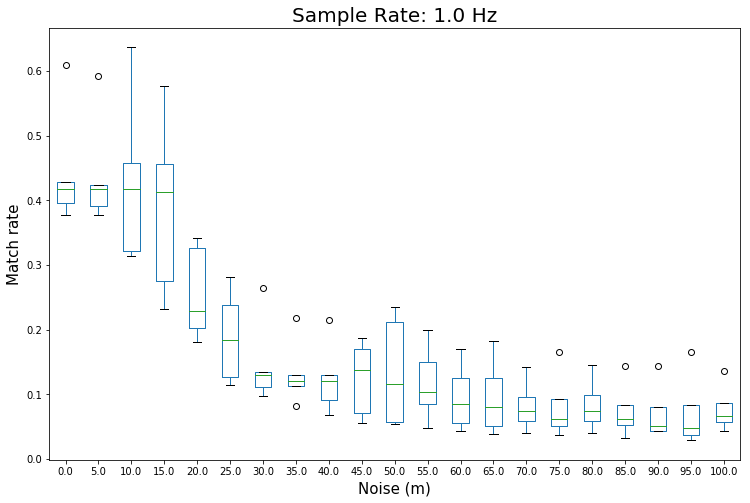

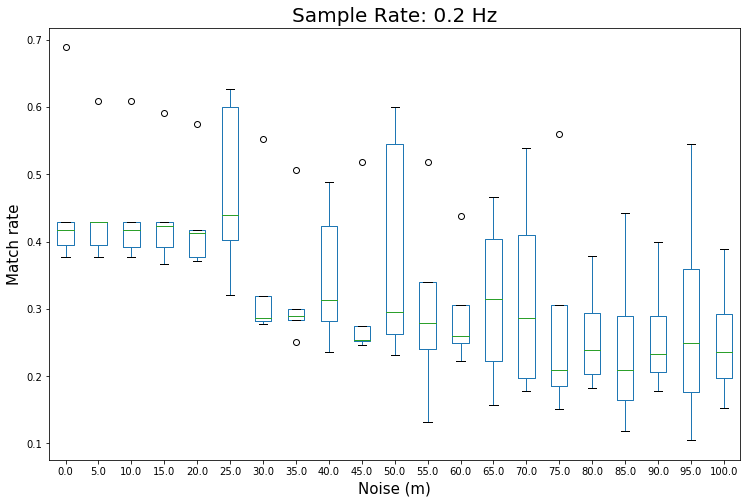

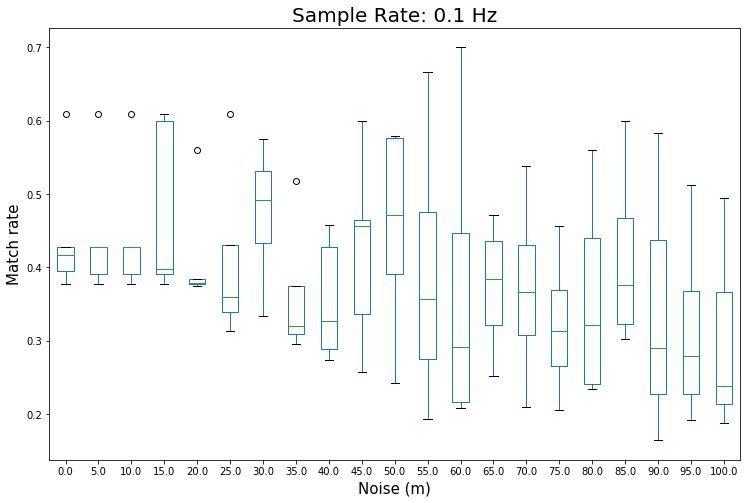

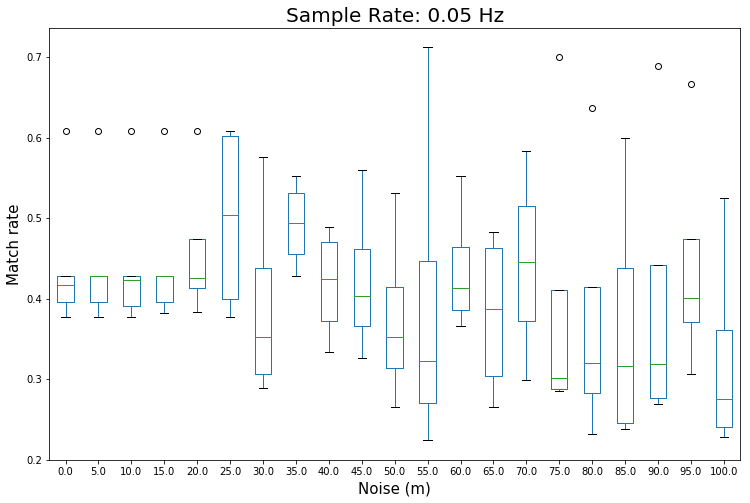

In [14]:
for rate in sampleRates:
    Hz = round(1 / rate, 3)
    fig, ax = plt.subplots(figsize=(12,8))
    df[df['sample_rate'] == rate].boxplot(column='score',by='noise', ax=ax, grid=False)
    ax.set_xlabel('Noise (m)', fontsize=15)
    ax.set_ylabel('Match rate', fontsize=15)
    ax.set_title('Sample Rate: {0} Hz'.format(Hz), fontsize=20)
    fig.suptitle('')
#     fig.savefig('./../data/score_vs_noise_{0}_Hz.png'.format(Hz))

In [8]:
data = df[['noise','score','sample_rate']].groupby(['sample_rate','noise']).agg('mean').reset_index()

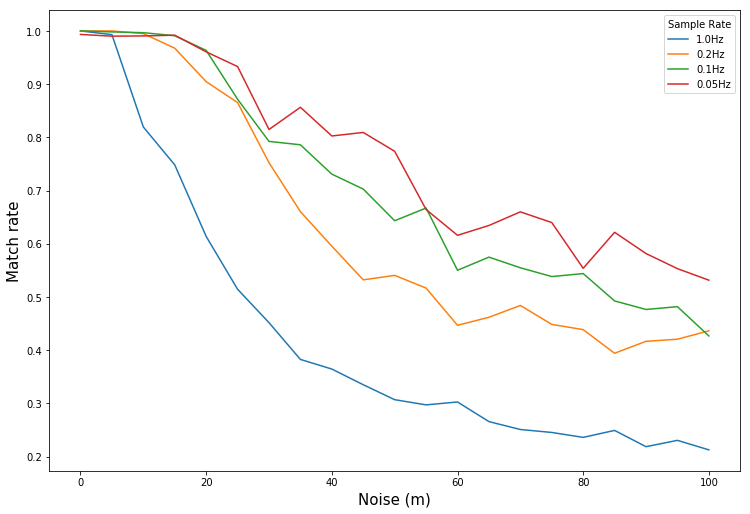

In [9]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
for rate in sampleRates:
    ax.plot(data.loc[data['sample_rate'] == rate, 'noise'],
            data.loc[data['sample_rate'] == rate, 'score'],
           label=str(round(1 / rate, 3)) + 'Hz')
ax.legend(title='Sample Rate')
ax.set_xlabel('Noise (m)', fontsize=15)
ax.set_ylabel('Match rate', fontsize=15)
# fig.savefig('score_vs_noise_by_sample_rate.png')

### 4. Visualize Routes

In [64]:
routeList = [trace for trace in os.listdir('../data/') if trace.endswith('json')]
fname = '../data/' + choice(routeList)

In [74]:
route = choice(routeList)
# origin = route[0].keys()[0]
origin = 'Watson and Son'
# destination = route[1].keys()[0]
destination = 'Walter & Elise Haas Fund'
noise = 30.0
sampleRate = 5
Hz = round(1 / sampleRate, 3)
fname = "../data/trace_{0}_to_{1}_w_{2}_m_noise_at_{3}_Hz.geojson".format(origin, destination, noise, Hz)

In [75]:
val.generate_route_map(fname, 13)

In [80]:
fname

'../data/trace_Watson and Son_to_Walter & Elise Haas Fund_w_30.0_m_noise_at_0.2_Hz.geojson'

In [86]:
csv = fname.replace('trace','matches').replace('geojson','csv')
matchDf = pd.read_csv(csv)
matchDf

,edge_seg,reporter_seg,min_valhalla_idx,max_valhalla_idx,min_reporter_idx,max_reporter_idx
0,1.450558e+11,1.450558e+11,11.0,12.0,9.0,11.0
1,1.482099e+11,1.482099e+11,16.0,16.0,14.0,16.0
2,1.801206e+11,1.801206e+11,24.0,35.0,24.0,24.0
3,NaN,1.833753e+11,NaN,NaN,17.0,17.0
4,1.848517e+11,1.848517e+11,3.0,4.0,2.0,4.0
5,NaN,1.858248e+11,NaN,NaN,0.0,0.0
6,1.942134e+11,1.942134e+11,18.0,19.0,18.0,19.0
7,NaN,2.262915e+11,NaN,NaN,16.0,17.0
8,NaN,3.007066e+10,NaN,NaN,24.0,24.0
9,NaN,3.010421e+10,NaN,NaN,25.0,25.0


### 5. Save the Scores to Master File

In [13]:
df.columns = [x.strip().replace(' ', '_') for x in df.columns]

In [14]:
df.to_csv('../data/master_scores.csv', index=False)

# OLD STUFF

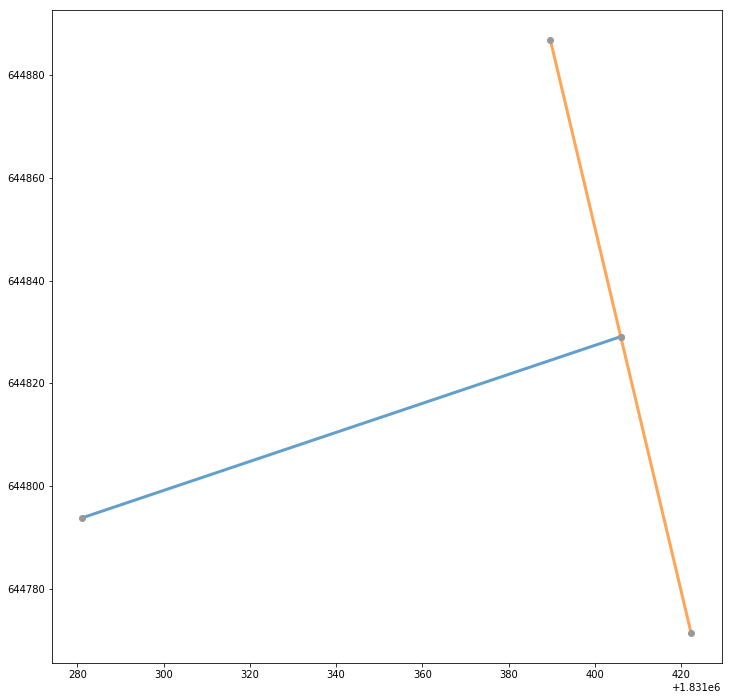

In [319]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(x, y, linewidth=3, alpha=0.7)
ax.plot(x, y, 'o',color='#999999' )
ax.plot(bx, by, linewidth=3, alpha=0.7)
ax.plot(bx, by, 'o',color='#999999' )